# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

**Assignment**
Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
   * Excel and Vensim are only supported on Windows
   * Vensim requires the DSS version of Vensim
   * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/). Also, if you don't have NetLogo installed, please get [NetLogo 6.3.0](https://ccl.northwestern.edu/netlogo/download.shtml)
   * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
   * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).


|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes [example scripts](https://github.com/quaquel/EMAworkbench/tree/master/ema_workbench/examples) for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel).
  * This [tutorial](https://emaworkbench.readthedocs.io/en/latest/basic_tutorial.html) also shows a simple model in Python, Vensim and Excel connected to the workbench.

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function.

In [1]:
# Some imports you may need
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, ScalarOutcome, Constant, MultiprocessingEvaluator, TimeSeriesOutcome, perform_experiments, ema_logging)

from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel

from ema_workbench.em_framework.samplers import LHSSampler
from ema_workbench.em_framework.salib_samplers import MorrisSampler, SobolSampler

from ema_workbench.analysis.plotting import lines, Density

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\.venv\Lib\site-packages\ema_workbench\connectors\__init__.py:19: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)
C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\.venv\Lib\site-packages\ema_workbench\connectors\__init__.py:34: ImportWarning: simio connector not available
  warnings.warn("simio connector not available", ImportWarning)


# 1 Python Model

In [2]:
from model.pred_prey import PredPrey

ema_logging.log_to_stderr(ema_logging.INFO)

# Create a Python model
python_model = Model('PredPreyPython', function=PredPrey)

python_model.run_length = 365

python_model.uncertainties = [
    RealParameter('prey_birth_rate', 0.015, 0.035),
    RealParameter('predation_rate', 0.0005, 0.003),
    RealParameter('predator_efficiency', 0.001, 0.004),
    RealParameter('predator_loss_rate', 0.04, 0.08)
]
python_model.outcomes = [
    TimeSeriesOutcome('TIME'),
    TimeSeriesOutcome('predators'),
    TimeSeriesOutcome('prey')
]

In [3]:
with (MultiprocessingEvaluator(python_model)as evaluator):
    experiments_python, outcomes_python = evaluator.perform_experiments(scenarios=50) 

[MainProcess/INFO] pool started with 20 workers
[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 36.33it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [4]:
print(outcomes_python['prey'].shape)
print(outcomes_python['predators'].shape)

# Removing the singleton dimension for both 'prey' and 'predators'
outcomes_python['prey'] = np.squeeze(outcomes_python['prey'], axis=1)
outcomes_python['predators'] = np.squeeze(outcomes_python['predators'], axis=1)

# Check the new shapes to ensure they are correct
print("Adjusted shape for prey:", outcomes_python['prey'].shape)
print("Adjusted shape for predators:", outcomes_python['predators'].shape)

(50, 1, 1461)
(50, 1, 1461)
Adjusted shape for prey: (50, 1461)
Adjusted shape for predators: (50, 1461)


(<Figure size 640x480 with 2 Axes>,
 {'prey': <Axes: title={'center': 'prey'}, xlabel='Time', ylabel='prey'>,
  'predators': <Axes: title={'center': 'predators'}, xlabel='Time', ylabel='predators'>})

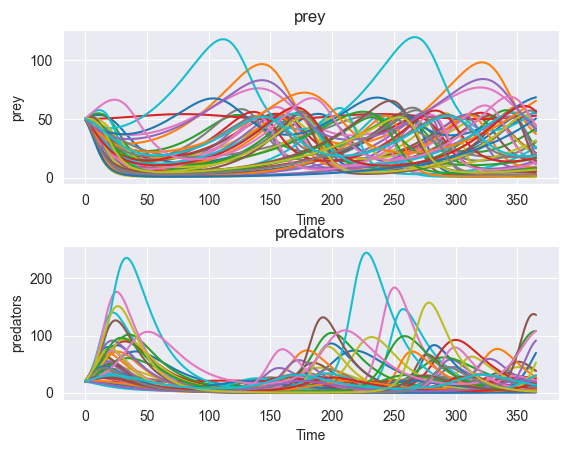

In [5]:
from ema_workbench.analysis import plotting
plotting.lines(experiments_python, outcomes_python, outcomes_to_show=['prey', 'predators'])


 ## 2 Vensim

In [6]:
# Enable logging
ema_logging.log_to_stderr(ema_logging.INFO)

# Instantiate the Vensim model
vensim_model = PysdModel("VensimPredPrey", "./model/PredPrey.mdl")

# Copy uncertainities from python model
vensim_model.uncertainties = python_model.uncertainties

# Define outcomes
vensim_model.outcomes = [
    TimeSeriesOutcome('predators'),
    TimeSeriesOutcome('prey')
]

In [7]:
# Run experiments
with MultiprocessingEvaluator(vensim_model) as evaluator:    
    experiments_sd, outcomes_sd = evaluator.perform_experiments(scenarios=50)

[MainProcess/INFO] pool started with 20 workers
[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
100%|██████████████████████████████████████████| 50/50 [00:04<00:00, 11.41it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [8]:
print(outcomes_python['prey'].shape)
print(outcomes_python['predators'].shape)

(50, 1461)
(50, 1461)


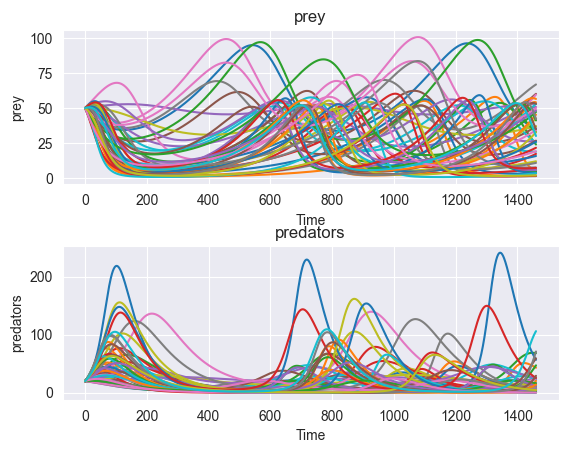

In [9]:
# Plotting the results for the Vensim/PySD model
lines(experiments_sd, outcomes_sd, outcomes_to_show=['prey', 'predators'])
plt.show()

# NetLogo Model

In [10]:
# Enable logging
ema_logging.log_to_stderr(ema_logging.INFO)

netlogo_model = NetLogoModel('PredPreyNetLogo', wd='./model/', model_file='PredPrey.mdl')

netlogo_model.run_length = 365

# Copy uncertainties from python model
netlogo_model.uncertainties = python_model.uncertainties

# Define outcomes
netlogo_model.outcomes = [
    TimeSeriesOutcome('TIME'),
    TimeSeriesOutcome('predators'),
    TimeSeriesOutcome('prey')
]


In [ ]:
# Set up the evaluator
with MultiprocessingEvaluator(netlogo_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=50)


[MainProcess/INFO] pool started with 20 workers
[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
  0%|                                                   | 0/50 [00:00<?, ?it/s]

In [ ]:
# Analysis
from ema_workbench.analysis import plotting

plotting.lines(experiments, outcomes, outcomes_to_show=['prey', 'predators'])

# Plots